# 03 - Interactive Viz

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Important Notes

- Make sure you push on GitHub your Notebook with all the cells already evaluated
- Note that maps do not render in a standard Github environment : you should export them to HTML and link them in your notebook.
- Remember that `.csv` is not the only data format. Though they might require additional processing, some formats provide better encoding support.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
- Please write all your comments in English, and use meaningful variable names in your code

## Background

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Unemployment rates are major economic metrics and a matter of concern for governments around the world. Though its definition may seem straightforward at first glance (usually defined as the number of unemployed people divided by the active population), it can be tricky to define consistently. For example, one must define what exactly unemployed means : looking for a job ? Having declared their unemployment ? Currently without a job ? Should students or recent graduates be included ? We could also wonder what the active population is : everyone in an age category (e.g. `16-64`) ? Anyone interested by finding a job ? Though these questions may seem subtle, they can have a large impact on the interpretation of the results : `3%` unemployment doesn't mean much if we don't know who is included in this percentage. 

In this homework you will be dealing with two different datasets from the statistics offices of the European commission ([eurostat](http://ec.europa.eu/eurostat/data/database)) and the Swiss Confederation ([amstat](https://www.amstat.ch)). They provide a variety of datasets with plenty of information on many different statistics and demographics at their respective scales. Unfortunately, as is often the case is data analysis, these websites are not always straightforward to navigate. They may include a lot of obscure categories, not always be translated into your native language, have strange link structures, â€¦ Navigating this complexity is part of a data scientists' job : you will have to use a few tricks to get the right data for this homework.

For the visualization part, install [Folium](https://github.com/python-visualization/folium) (*HINT*: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!). Folium's `README` comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find two `.topojson` files, containing the geo-coordinates of 

- European countries (*liberal definition of EU*) (`topojson/europe.topojson.json`, [source](https://github.com/leakyMirror/map-of-europe))
- Swiss cantons (`topojson/ch-cantons.topojson.json`) 

These will be used as an overlay on the Folium maps.

## Assignment

1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [RÃ¶stigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

In [31]:
import os
import pandas as pd
import json
import numpy as np
import folium
#To create colormaps
import branca
from branca.colormap import  LinearColormap
#Find  here: https://github.com/perrygeo/jenks
#to run the code you need to install jenks: pip install -e "git+https://github.com/perrygeo/jenks.git#egg=jenks"
# and the requirements: Cython==0.20, Numpy==1.8.0, pytest, setuptools
from jenks import jenks
import matplotlib.pyplot as plt
%matplotlib inline

## 1. European Unemployment rates

Q: *Go to the eurostat website and try to find a dataset that includes the european unemployment rates at a recent date.
Use this data to build a Choropleth map which shows the unemployment rate in Europe at a country level. Think about the colors you use, how you decided to split the intervals into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.*

In [2]:
DATA_FOLDER = './Data'
EU_DATA_FOLDER=DATA_FOLDER + '/LFS-quaterly-TotalUnemployment' # LFS: Labour Force Survey

#URGAN: Unemployment Rates by Gender, Age and Nationality
#use separated sheet to get  the sheet'Data' with the total (male + female) UR
#EU_URN: EUrope Unemployment Rates by Nationality
eu_urn= pd.read_excel(EU_DATA_FOLDER + '/lfsq_urgan-2.xls', sheetname='Data', header=11);

#keep most recent Unemployment rates here the second quarter of 2017 i.e 2017Q2
eu_urn = eu_urn[['GEO/TIME','2017Q2']]
eu_urn

,GEO/TIME,2017Q2
0,European Union (28 countries),7.6
1,European Union (27 countries),7.6
2,European Union (15 countries),8.2
3,Euro area (19 countries),9.0
4,Euro area (18 countries),9.0
5,Euro area (17 countries),9.0
6,Belgium,7.0
7,Bulgaria,6.3
8,Czech Republic,3.0
9,Denmark,5.5


In [3]:
#drop  rows where GEO/TIME = Europe union and Europe area (index from 0 to 5)
# GEO/TIME  = ":" (index 41)
#GEO/TIME = "NaN" (index 39)
#GEO/TIME = "Special value" (index 40)
eu_urn= eu_urn.drop([0,1,2,3,4,5,41,39,40],axis=0)

#change the columns name
eu_urn= eu_urn.rename(columns={'GEO/TIME': 'Country', '2017Q2': 'Unemployment (%)'})

#change countries name to merge with the topojson data later
eu_urn = eu_urn.set_value(10,'Country','Germany')
eu_urn = eu_urn.set_value(37,'Country','The former Yugoslav Republic of Macedonia')
nb_countries=len(eu_urn)

#load TOPOJSON
topo= pd.read_json('./topojson/europe.topojson.json',typ= 'series')
#recover Europe geometries and convert to df 
eu_topo= pd.DataFrame(topo['objects']['europe']['geometries']) #convert list of dict to df, keys become column names
#get ids and names of the countries
countries_id=eu_topo['id']
countries_name=pd.DataFrame(list(eu_topo['properties'].values))#properties vlaues are dict, pass them to list of dict
#create DF with ids and names of countries
eu_code=pd.DataFrame()
eu_code['id']=countries_id
eu_code['Country']=countries_name['NAME']
eu_code =eu_code.sort_values('Country') #alphabetical order


#MERGE ids and Unemployment rates using the countries' name
eu_urn = pd.merge(eu_code,eu_urn, 'inner')
eu_urn = eu_urn.set_index('id')
print('Check no countries from eurostat are missing: ', nb_countries==len(eu_urn))
eu_urn

Check no countries from eurostat are missing:  True


,Country,Unemployment (%)
id,,
AT,Austria,5.4
BE,Belgium,7.0
BG,Bulgaria,6.3
HR,Croatia,11.0
CY,Cyprus,10.6
CZ,Czech Republic,3.0
DK,Denmark,5.5
EE,Estonia,7.0
FI,Finland,9.9


In [4]:
#Create map of Europe centered on Switzerland lat=46, long=6
m_eu = folium.Map([46, 6], tiles='Mapbox Bright', zoom_start=4)

#Data to map
map_data= eu_urn['Unemployment (%)']


#Data classification for the choropleth map: Natural breaks (Jenks) Classification
bins = jenks(list(map_data.values), 5) #bins to split the intervals of the colormap into data classes

#Create a step colormap using the sequential colormap YlOrRd and the previously defined bins
colormap = branca.colormap.linear.YlOrRd.to_step(index = bins)
colormap.caption= 'Unemployment Rate (%)' 

def style_function(feature):
    val=map_data.get(feature['id'][-5:], None) 
    if val is None: #if unemployment rate not given for a country in the topojson
        return {       
        'color' : 'black',
        'fillColor' : 'grey',
        'fillOpacity':0.3,
        'dashArray' : '5, 5',
        'lineOpacity':1,
        'weight':0.5
 }
    else: #else map the unemployment rates to the colormap
        return  {
        'color': 'black',
        'fillColor': colormap(val),
        'fillOpacity': 0.5,
        'lineOpacity':1,
        'weight': 0.5
 }
    
    
folium.TopoJson(open('./topojson/europe.topojson.json'),
                'objects.europe',style_function=style_function).add_to(m_eu)

#add the colormap to render the legend
m_eu.add_child(colormap)

m_eu.save('./Data/maps/EU_unemployment_rates.html')

m_eu

In [5]:
#Create map
m_eu = folium.Map([46, 6], tiles='Mapbox Bright', zoom_start=4)

min_ur=min(map_data); #min of the EU unemployment rates
max_ur=max(map_data); #max of the EU unemployment rates
swiss_ur= eu_urn.get_value('CH','Unemployment (%)')#Switzerland unemployment rates

#UR inferior to the Switzerland UR
eu_urn_inf = eu_urn[(eu_urn['Unemployment (%)']> min_ur) & (eu_urn['Unemployment (%)'] < swiss_ur)]['Unemployment (%)']
#UR superior to the Switzerland UR
eu_urn_sup = eu_urn[(eu_urn['Unemployment (%)']< max_ur) & (eu_urn['Unemployment (%)'] > swiss_ur)]['Unemployment (%)']

#Jenks classification for the UR inferior to Swiss UR
j1=jenks(eu_urn_inf,1);
#Jenks classification for the UR superior to Swiss UR
j2=jenks(eu_urn_sup,3); # 3 here, because it's the case for many countries
#add the Switzerland UR to get a colormap center on the Swiss UR
j1.append(swiss_ur)
bins=j1 + j2

#Create the colormap
colors = ['green', 'white', 'red'] 
colors_index=[min_ur,swiss_ur,max_ur] #UR corresponding the the colors, the transition from green to red is map to 
#the Swiss UR, so that the colormap is dispersive and centered on the Swiss UR
colormap= LinearColormap(colors=colors,index=colors_index, vmin=min_ur, vmax= max_ur)
colormap=colormap.to_step(index=bins) #apply the bins to the colormap
colormap.caption= 'Unemployment Rate (%)'

def style_function(feature):
    val=map_data.get(feature['id'][-5:], None) 
    if val is None: #if unemployment rate not given for a country in the topojson
        return {       
        'color' : 'black',
        'fillColor' : 'grey',
        'fillOpacity':0.3,
        'dashArray' : '5, 5',
        'lineOpacity':1,
        'weight':0.5
        
 }
    elif feature['id'][-5:] == 'CH' :#if Switzerland
        return {
        'fillColor' : colormap(val),
        'fillOpacity':0.5,
        'lineOpacity':1,
        'weight' : 3 #highlight it's bounderies
 } 
    else: #else map the unemployment rates to the colormap
        return  {
        'color': 'black',
        'fillColor': colormap(val),
        'fillOpacity': 0.5,
        'lineOpacity':1,
        'weight': 0.5      
 }
    
folium.TopoJson(open('./topojson/europe.topojson.json'),
                'objects.europe',style_function=style_function).add_to(m_eu)


m_eu.add_child(colormap)


m_eu.save('./Data/maps/EU_vs_Swiss.html')




m_eu

We firtly load a dataset from the [amstat](https://www.amstat.ch) recovering the datas for September 2017. We took in account the unemployement rate, the number os registered unemployed people, the number of long term unemployed people (who do not have a job for more than two years), the number of job seekers and the employed job seekers. The data were available for each canton.

In [6]:
#load data
swiss_unemployement = pd.read_csv('Data/swiss_unemployement.csv',header=1,quotechar='"',encoding='utf-16le')

#clean the data
swiss_unemployement.drop(['Mois','Septembre 2017','Septembre 2017.1','Septembre 2017.2','Septembre 2017.3','Septembre 2017.4'],1,inplace=True)
swiss_unemployement.columns = [swiss_unemployement.columns[0],
                               swiss_unemployement['Total'][0],
                               swiss_unemployement['Total.1'][0],
                               swiss_unemployement['Total.2'][0],
                               swiss_unemployement['Total.3'][0],
                               swiss_unemployement['Total.4'][0]]

swiss_unemployement.drop(0,0,inplace=True)
swiss_unemployement.reset_index(drop=True,inplace=True)

swiss_unemployement['Taux de chômage']=swiss_unemployement['Taux de chômage'].astype(float)
swiss_unemployement['Chômeurs inscrits'] = swiss_unemployement['Chômeurs inscrits'].str.replace('\'','').astype('int')
swiss_unemployement['Chômeurs de longue durée'] = swiss_unemployement['Chômeurs de longue durée'].str.replace('\'','').astype('int')
swiss_unemployement['Demandeurs d\'emploi'] = swiss_unemployement['Demandeurs d\'emploi'].str.replace('\'','').astype('int')
swiss_unemployement['Demandeurs d\'emploi non chômeurs'] = swiss_unemployement['Demandeurs d\'emploi non chômeurs'].str.replace('\'','').astype('int')

In order to compute meaningful informations we needed the active population of each contons. Since it is not given on the website, we decided to compute an estimation by dividing the number of job seekers by the unemployement rate (as explain in the description). We decided to also compute the percentage of long-term unemployed people on the total of unemployed people, the registered enemployed people rate (lower than the unemployement rate) and the percentage of unemployed people among all the job seekers.

In [7]:
#adding new columns

swiss_unemployement['Population active (estimation)'] = (100 * swiss_unemployement['Demandeurs d\'emploi'].astype(float)
                                                         /swiss_unemployement['Taux de chômage']).astype(int)
swiss_unemployement['Taux de chômeurs longue durée'] = 100*(swiss_unemployement['Chômeurs de longue durée'].astype(float)
                                                         /(swiss_unemployement['Chômeurs de longue durée'] + swiss_unemployement['Chômeurs inscrits']))
swiss_unemployement['Taux de chômeurs inscrits'] = 100*(swiss_unemployement['Chômeurs inscrits'].astype(float)
                                                    /swiss_unemployement['Population active (estimation)'])
swiss_unemployement['Taux de chômeurs dans les demandeurs d\'emploi'] = 100*(swiss_unemployement['Chômeurs inscrits'].astype(float)
                                                                         /swiss_unemployement['Demandeurs d\'emploi'] )


swiss_unemployement

,Canton,Taux de chômage,Chômeurs inscrits,Chômeurs de longue durée,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Population active (estimation),Taux de chômeurs longue durée,Taux de chômeurs inscrits,Taux de chômeurs dans les demandeurs d'emploi
0,Zurich,3.3,27225,4753,34156,6931,1035030,14.863344,2.630359,79.707811
1,Berne,2.4,13658,2336,18385,4727,766041,14.605477,1.782933,74.288822
2,Lucerne,1.7,3885,453,6756,2871,397411,10.442600,0.977577,57.504440
3,Uri,0.6,112,13,257,145,42833,10.400000,0.261481,43.579767
4,Schwyz,1.7,1455,189,2229,774,131117,11.496350,1.109696,65.275908
5,Obwald,0.7,153,10,319,166,45571,6.134969,0.335740,47.962382
6,Nidwald,1.0,248,24,436,188,43600,8.823529,0.568807,56.880734
7,Glaris,1.8,416,78,713,297,39611,15.789474,1.050213,58.345021
8,Zoug,2.3,1543,248,2615,1072,113695,13.847013,1.357140,59.005736
9,Fribourg,2.7,4466,486,7837,3371,290259,9.814216,1.538626,56.986092


We can then load the map. In order to synchronize the map with the dataset, we need to have the same label on both. The name are in different language in the map and the dataset, but happily they are in the same order (the traditionnal swiss cantons order). We can simply add a column in the dataset for the cantons ID given in the json map.

In [8]:
#load map

canton_topo_path = os.path.join('topojson','ch-cantons.topojson.json')
topo_json_data = json.load(open(canton_topo_path))

In [9]:
#add id to synchronize the dataset and the map

N_canton = len(topo_json_data['objects']['cantons']['geometries'])
swiss_unemployement['id']=swiss_unemployement['Canton']

for i in range(N_canton):
    swiss_unemployement['id'].loc[i] = topo_json_data['objects']['cantons']['geometries'][i]['id']

/home/samuel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
#define the map

center_coord = [46.8011111,8.2266667]

swiss_map = folium.Map(location=center_coord,
            tiles='cartodbpositron',           
            zoom_start=7)


def add_layer_to_map(dataset,input_map,path,column,name,scale_min,scale_max):
    scale = jenks(list(dataset[column].values), 5)
    serie = dataset.set_index('id')[column]
    input_map.choropleth(geo_data=open(path), topojson='objects.cantons', data=serie,
        columns=['id', column],
        key_on='id',
        threshold_scale=scale,
        fill_color='YlOrRd', fill_opacity=0.5, line_opacity=0.2,
        name=name,
        legend_name=name,
        highlight = True)

    
add_layer_to_map(swiss_unemployement,swiss_map,canton_topo_path,
                 'Taux de chômage','Unemployment rate',0.,6.)
add_layer_to_map(swiss_unemployement,swiss_map,canton_topo_path,
                 'Taux de chômeurs longue durée','Percentage of long term unemployed people',5.,22.)
add_layer_to_map(swiss_unemployement,swiss_map,canton_topo_path,
                 'Taux de chômeurs inscrits','Percentage of registered unemployed people',0.,5.)
add_layer_to_map(swiss_unemployement,swiss_map,canton_topo_path,
                 'Taux de chômeurs dans les demandeurs d\'emploi','Percentage of unemployed people in job seekers',40.,80.)

folium.LayerControl().add_to(swiss_map)

In [11]:
swiss_map

Firstly, we can see on this map the distribution of the unemployement rate in Switzerland's different cantons. With this map we can see two major trends, firtly the latin cantons (french or italian) seems to have a higher overall unemployement rate. We can see that the worst cantons (Geneva, Neuchâtel) are french ones and that latin cantons have in average a higher unemployement rate than the surrounding german cantons. Another major trend we can extract is that the urban cantons have in general a higher unemployement rate (like Zürich or Basel-Town) when the cantons where the purcentage of urban population is lower appears to be lower (like Uri or Schwytz).

We can see a mostly similar repartitions with the three other maps. For example we can see that Jura, Neuchâtel and Schaffhausen have a high percentage in long term unemployed people, meaning it is hard for them to find jobs. The percentage of registered unemployed people is strongly correlated with the unemployement rate (but inferior). Concerning the percentage of unemployed people among job seekers, we can't see any clear national tendency but Zürich has clearly the higher percentage.

In [12]:
data_path = os.path.join(os.path.dirname(os.getcwd()),'03 - Interactive Viz','Data','data_3.csv') 

Load and clean data

In [13]:
swiss_foreign_unemployment = pd.read_csv(data_path, skiprows=[0], encoding='utf-16le')
swiss_foreign_unemployment = swiss_foreign_unemployment.drop(['Mois'], axis=1)

new_column_names = swiss_foreign_unemployment.values[0]
old_column_names = swiss_foreign_unemployment.columns.values

for i in range(2,5):
    swiss_foreign_unemployment = swiss_foreign_unemployment.rename(columns={old_column_names[i]: new_column_names[i]})

swiss_foreign_unemployment = swiss_foreign_unemployment.drop([0], axis=0)
swiss_foreign_unemployment = swiss_foreign_unemployment.drop(swiss_foreign_unemployment.columns[[3,5]], axis=1)
swiss_foreign_unemployment = swiss_foreign_unemployment.loc[:,~swiss_foreign_unemployment.columns.duplicated()]
swiss_foreign_unemployment['Taux de chômage']=swiss_foreign_unemployment['Taux de chômage'].astype(float)

In [15]:
topo_json_data = json.load(open(canton_topo_path))
N_canton = len(topo_json_data['objects']['cantons']['geometries'])

swiss_foreign_unemployment['id'] = swiss_foreign_unemployment['Canton']

for i in range(N_canton):
    for j in range(2):
        swiss_foreign_unemployment.set_value(2*i+j+1,'id',topo_json_data['objects']['cantons']['geometries'][i]['id'])


In [16]:
suisses = (swiss_foreign_unemployment[swiss_foreign_unemployment['Nationalité'] == 'Suisses']).reset_index(drop=True)
etrangers = (swiss_foreign_unemployment[swiss_foreign_unemployment['Nationalité'] == 'Etrangers']).reset_index(drop=True)

In [17]:

swiss_foreign_map = folium.Map([46.8011111,8.2266667], tiles='cartodbpositron', zoom_start=7)

add_layer_to_map(suisses,swiss_foreign_map,canton_topo_path,
                 'Taux de chômage','Unemployment Swiss',0.,4.8)
add_layer_to_map(etrangers,swiss_foreign_map,canton_topo_path,
                 'Taux de chômage','Unemployment Foreign',0.,9.)

folium.LayerControl().add_to(swiss_foreign_map)

swiss_foreign_map

Part with age differences

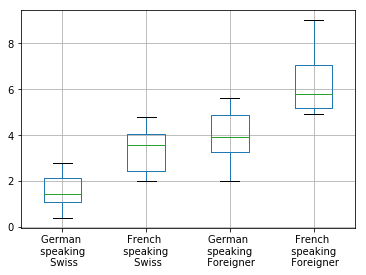

In [40]:
region=pd.Series(['A','A','A','A','A','A','A','A','A','R','A','A','A','A','A','A','A','A','A','A','A','R','R','R','R','R'])
suisses['Region']=region
etrangers['Region']=region

total_cantons=pd.DataFrame(index=range(20),
                           columns=['German \n speaking \n Swiss',
                                    'French \n speaking \n Swiss',
                                    'German \n speaking \n Foreigner',
                                    'French \n speaking \n Foreigner'])
total_cantons['German \n speaking \n Swiss']=suisses[suisses['Region'] == 'A']['Taux de chômage'].reset_index(drop=True)
total_cantons['French \n speaking \n Swiss']=suisses[suisses['Region'] == 'R']['Taux de chômage'].reset_index(drop=True)
total_cantons['German \n speaking \n Foreigner']=etrangers[etrangers['Region'] == 'A']['Taux de chômage'].reset_index(drop=True)
total_cantons['French \n speaking \n Foreigner']=etrangers[etrangers['Region'] == 'R']['Taux de chômage'].reset_index(drop=True)

total_cantons.boxplot()